In [1]:
# disable warning
import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'

import pygsti
import numpy as np

import matplotlib.pyplot as plt

ws = pygsti.report.Workspace()
ws.init_notebook_mode(autodisplay=True)

Consider the CPTP map given by

$$
\varepsilon(\rho) = \kappa [e^{i\theta(\cos \phi X + \sin \phi Y)}\rho e^{-i\theta(\cos \phi X + \sin \phi Y)}] + (1 - \kappa) [\cos^2 \theta \rho + \sin^2\theta [cos^2 \phi X \rho X + \sin^2 \phi Y \rho Y]]
$$

where $0 \leq \kappa \leq 1$.

First, define

$$
U = e^{i\theta(\cos \phi X + \sin \phi Y)}
$$

and observe that it is a unitary transformation. Recall that trace is preserved under conjugation by cyclicity of trace. So, using the aforementioned and linearity of trace

$$
Tr[\varepsilon(\rho)] = \kappa(Tr[U\rho U^\dagger]) + (1-\kappa)[\cos^2 \theta Tr[\rho] + \sin^2 \theta[cos^2 \phi Tr[X \rho X] + \sin^2 \phi Tr[Y\rho Y]]] \\
= \kappa(Tr[\rho]) + (1-\kappa)[\cos^2 \theta Tr[\rho] + \sin^2 \theta[cos^2 \phi Tr[\rho] + \sin^2 \phi Tr[\rho]]] \\
= \kappa(Tr[\rho]) + (1 - \kappa) [(\cos^2 \theta + \sin^2 \theta) Tr[\rho]] \\
= Tr[\rho]
$$

In [2]:
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import mixed_unitary_error
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.quantum_info.operators.channel.choi import Choi
from qiskit.tools.qi.qi import choi_to_rauli

In [3]:
from scipy.linalg import expm
from numpy import sqrt

I = np.matrix([[1, 0], [0, 1]])
pauli_X = np.matrix([[0, 1], [1, 0]])
pauli_Y = np.matrix([[0, -1j], [1j, 0]])

In [4]:
def gen_error_channel(kappa, theta, phi):
    U = expm(1j * theta * (np.cos(phi) * pauli_X + np.sin(phi) * pauli_Y))

    return mixed_unitary_error([
    (U, kappa),
    (I, (1 - kappa) * np.cos(theta) ** 2 ),
    (pauli_X, (1-kappa) * np.sin(theta) ** 2 * np.cos(phi) ** 2 ),
    (pauli_Y, (1-kappa) * np.sin(theta) ** 2 * np.sin(phi) ** 2 )
    ])

In [5]:
kappa = 0.8
theta = np.pi / 16 # theta should be restricted to small rotations for small errors
phi = np.pi / 8 # phi determines X and Y error mixing

In [6]:
error_channel = gen_error_channel(kappa, theta, phi)

def error_channel_to_choi(error_channel):
    #print(error_channel)

    # choi representation
    error_channel_choi = Choi(error_channel)
    
    #print(error_channel_choi)

    # change to pauli basis
    # NOTE - choi matrix should have trace 1 ... looks like qiskit does not normalize
    error_channel_superop = choi_to_rauli(error_channel_choi.data / np.trace(error_channel_choi.data)) 
    
    #print("Trace: ", np.trace(error_channel_superop))
    
    # hermitian basis so elements should be real
    
    #print("error channel in pauli basis (verify real components are neglible):\n", error_channel_superop)
    
    return error_channel_superop.real

error_channel_superop = error_channel_to_choi(error_channel)

In [7]:
#cnot = np.matrix (
#        [[1, 0, 0, 0],
#        [0, 1, 0, 0],
#        [0, 0, 0, 1],
#        [0, 0, 1, 0]]
#        )
#
#gx = (1/ np.sqrt(2)) * np.matrix(
#        [[1, -1j], [-1j, 1]]
#        )
#
#gx = (1/ np.sqrt(2)) * np.matrix(
#        [[1, -1], [1, 1]]
#        )

In [8]:
gi_nn = np.identity(4,'d') # 4x4 identity matrix
gx_nn = [[1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 0,-1],
      [0, 0, 1, 0]] # pi/2 X-rotation in Pauli basis

gy_nn = [[1, 0, 0, 0],
      [0, 0, 0, 1],
      [0, 0, 1, 0],
      [0,-1, 0, 0]] # pi/2 Y-rotation in Pauli basis
      
def gen_error_model(error_channel_superop):
    # apply error channel

    gi = np.dot(error_channel_superop, gi_nn)
    gx = np.dot(error_channel_superop, gx_nn)
    gy = np.dot(error_channel_superop, gy_nn)

    #mdl0 = pygsti.construction.build_explicit_model((0), [(),      ('Gx',0),    ('Gy',0)], ["I(0)","X(pi/2,0)", "Y(pi/2,0)"]) 
    #print(mdl0)

    # Initialize an empty Model object
    # Designate the basis being used for the matrices and vectors below 
    # as the "Pauli product" basis of dimension 2 - i.e. the four 2x2 Pauli matrices I,X,Y,Z

    mdl = pygsti.objects.ExplicitOpModel(['Q0'],'pp') # default is pauli basis, but emphasized because modifiable 

    #Populate the Model object with states, effects, gates,
    # all in the *normalized* Pauli basis: { I/sqrt(2), X/sqrt(2), Y/sqrt(2), Z/sqrt(2) }
    # where I, X, Y, and Z are the standard Pauli matrices.

    mdl['rho0'] = [ 1/sqrt(2), 0, 0, 1/sqrt(2) ] # density matrix [[1, 0], [0, 0]] in Pauli basis
    mdl['Mdefault'] = pygsti.objects.UnconstrainedPOVM(
        {'0': [ 1/sqrt(2), 0, 0, 1/sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
         '1': [ 1/sqrt(2), 0, 0, -1/sqrt(2) ] }) # projector onto [[0, 0], [0, 1]] in Pauli basis

    mdl['Gi'] = gi
    mdl['Gx'] = gx

    mdl['Gy'] = gy
    return mdl

mdl = gen_error_model(error_channel_superop)
print(mdl)


rho0 = FullSPAMVec with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullSPAMVec with dimension 4
 0.71   0   0 0.71

1: FullSPAMVec with dimension 4
 0.71   0   0-0.71



Gi = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.99 0.02-0.12
   0 0.02 0.94 0.28
   0 0.12-0.28 0.92


Gx = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.99-0.12-0.02
   0 0.02 0.28-0.94
   0 0.12 0.92 0.28


Gy = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.12 0.02 0.99
   0-0.28 0.94 0.02
   0-0.92-0.28 0.12






In [9]:
from pygsti.construction import std1Q_XYI

# 1) get the target Model
mdl_ideal = std1Q_XYI.target_model()

# 2) get the building blocks needed to specify which circuits are needed
prep_fiducials, meas_fiducials = std1Q_XYI.prepStrs, std1Q_XYI.effectStrs

print("Prep Strs: ", prep_fiducials)
print("Effect Strs: ", meas_fiducials)

germs = std1Q_XYI.germs
maxLengths = [1] # roughly gives the length of the sequences used by GST

print("Germs: ", germs)

listOfExperiments = pygsti.construction.make_lsgst_experiment_list(
    mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

Prep Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Effect Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Germs:  [Circuit(Gi), Circuit(Gx), Circuit(Gy), Circuit(GxGy), Circuit(GxGxGy), Circuit(GxGyGy), Circuit(GxGyGi), Circuit(GxGiGy), Circuit(GxGiGi), Circuit(GyGiGi), Circuit(GxGyGyGi), Circuit(GxGxGyGxGyGy)]


In [10]:
def generate_gst_data(m):
    # add seed for deterministic
    return pygsti.construction.generate_fake_data(m, listOfExperiments, nSamples=1000,
                                            sampleError="binomial")
    
    # to perform GST...
    # pygsti.do_stdpractice_gst(d, mdl_ideal, prep_fiducials, meas_fiducials, 
    #                               germs, maxLengths, modes="TP,Target", verbosity=0)
    
def gen_error_data(kappa, theta, phi):
    error_channel = gen_error_channel(kappa, theta, phi)
    error_channel_superop = error_channel_to_choi(error_channel)
    m = gen_error_model(error_channel_superop)
    return generate_gst_data(m)

def no_noise_gst():
    return generate_gst_data(mdl_ideal)

In [11]:
def get_gst_features(res):
    d = []
    for idx, k in enumerate(res.keys()):
        row = res.get_row(k)
        for lbl in row.counts.keys():
            if idx % 2 == 0:
                d.append(row[lbl] / 1000.)
                
    return np.array(d)

In [12]:
kappa = 0.8
theta = np.pi / 16 # theta should be restricted to small rotations for small errors
phi = np.pi / 8 # phi determines X and Y error mixing

err_fv = get_gst_features(
            gen_error_data(kappa, theta, phi)
            )

nn_fv = get_gst_features(
            no_noise_gst()
            )

print("no noise: ", nn_fv)
print("noisy: ", err_fv)

no noise:  [1.    0.    0.51  0.49  0.5   0.5   0.493 0.507 0.519 0.481 0.    1.
 0.495 0.505 0.508 0.492 0.499 0.501 0.    1.    0.477 0.523 0.496 0.504
 1.    0.    0.51  0.49  0.514 0.486 0.487 0.513 0.486 0.514 1.    0.
 0.513 0.487 0.    1.    0.474 0.526 0.    1.    0.472 0.528 0.523 0.477
 0.509 0.491 0.48  0.52  0.    1.    0.493 0.507 1.    0.    0.483 0.517
 0.    1.    1.    0.    0.505 0.495 1.    0.    0.    1.    0.492 0.508
 1.    0.    0.485 0.515 0.499 0.501 0.503 0.497 0.511 0.489 0.    1.
 0.52  0.48  0.    1.    0.505 0.495 0.505 0.495]
noisy:  [1.    0.    0.552 0.448 0.159 0.841 0.653 0.347 0.462 0.538 0.036 0.964
 0.489 0.511 0.471 0.529 0.639 0.361 0.594 0.406 0.256 0.744 0.636 0.364
 0.964 0.036 0.567 0.433 0.073 0.927 0.741 0.259 0.682 0.318 0.558 0.442
 0.632 0.368 0.06  0.94  0.46  0.54  0.218 0.782 0.49  0.51  0.915 0.085
 0.094 0.906 0.292 0.708 0.676 0.324 0.371 0.629 0.922 0.078 0.68  0.32
 0.076 0.924 0.929 0.071 0.121 0.879 0.835 0.165 0.166 0.834 0.53

92


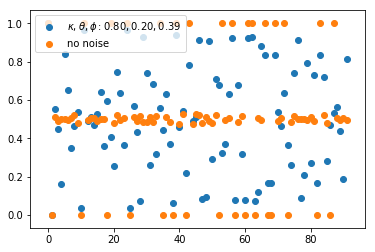

In [13]:
plt.figure()

print(len(err_fv))

plt.scatter(np.arange(92), err_fv, label=r"$\kappa, \theta, \phi: %.2f,%.2f,%.2f$" % (kappa, theta, phi))
plt.scatter(np.arange(92), nn_fv, label="no noise")

plt.legend()

plt.show()

In [17]:
from tqdm.autonotebook import tqdm, trange # progress bar

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [18]:
kappa_trials = 9
theta_trials = 9
phi_trials = 9
sample_trials = 10

# incoherent vs. coherent ratio
kappas = np.linspace(0, 1.0, num=kappa_trials)
# corresponds to error intensity
# should be >0 to avoid overlap with no noise dataset
# taken as fraction of pi/2 rotation
thetas = np.linspace(1e-2, 0.5, num=theta_trials)
# corresponds to bit-flip vs Y mixing
phis = np.linspace(0, np.pi , num=phi_trials)

In [19]:
# no noise trials

nn_fm = []
for i in trange(sample_trials * kappa_trials * theta_trials * phi_trials):
    nn_fv = get_gst_features(
            no_noise_gst()
            )
    
    # (kappa, theta, phi) = (1., 0., 0.)
    nn_fv = np.append(nn_fv, (1., 0., 0.))
    # category 0 (no noise)
    nn_fv = np.append(nn_fv, 0) 
    
    nn_fm.append(nn_fv)

nn_fm = np.array(nn_fm)
    

 10%|█         | 740/7290 [00:30<01:55, 56.91it/s]

In [21]:
# noisy trials

err_fm = []

# sample trials per (\kappa, \theta, \phi)
for i in trange(sample_trials):
    for kappa in tqdm(kappas):
        for theta in thetas:
            for phi in phis:
                theta_angle = theta * (np.pi / 2) # angle
                
                err_fv = get_gst_features(
                    gen_error_data(kappa, theta_angle, phi)
                )

                # noise features
                err_fv = np.append(err_fv, [kappa, theta, phi])
                
                # category 1 (noisy)
                err_fv = np.append(err_fv, 1) 

                err_fm.append(err_fv)

err_fm = np.array(err_fm)
    

In [22]:
%store nn_fm
%store err_fm

Stored 'nn_fm' (ndarray)
Stored 'err_fm' (ndarray)


In [37]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = np.concatenate((err_fm, nn_fm))

# only train with gst data as feature vectors
X = data[:, :92]
print(len(X[0]))

# use noise class as labelling
y = data[:, -1]
y_phi = data[:, -2]
y_theta = data[:, -3]
y_kappa = data[:, -4]

ss = StandardScaler()
data_trans = ss.fit_transform(X)

pca = PCA(2)
data_trans = pca.fit_transform(data_trans)

print("Explained variance: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

92
Explained variance:  [0.31763574 0.18733053]
Singular values:  [645.60174611 495.79745441]


In [38]:
# grid for plotting decision bdry

x_min = np.min(data_trans[:,0])
x_max = np.max(data_trans[:, 0])
y_min = np.min(data_trans[:, 1])
y_max = np.max(data_trans[:, 1])
h = .02  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

def get_contour_map(clf):
    Z = clf.predict(grid) 
    return Z.reshape(xx.shape)

In [39]:
# RBF kernel
clf = svm.SVC(kernel='rbf', gamma='auto')

def fit_and_score_svm(clf, data, lbl):
    clf.fit(data, lbl)
    acc = clf.score(data, lbl)
    print("acc: ", acc)
    # contour to plot decision boundary
    Z = get_contour_map(clf)
    return acc, Z

phi_labels = (phi_trials * y_phi / np.max(phis)).astype(int)
theta_labels = (theta_trials * y_theta / np.max(thetas)).astype(int)
kappa_labels = (kappa_trials * y_kappa / np.max(kappas)).astype(int)

acc, Z = fit_and_score_svm(clf, data_trans, y)
print("phi...")
acc_phi, Z_phi = fit_and_score_svm(clf, data_trans, phi_labels)
print("theta...")
acc_theta, Z_theta = fit_and_score_svm(clf, data_trans, theta_labels)
print("kappa...")
acc_kappa, Z_kappa = fit_and_score_svm(clf, data_trans, kappa_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled 

In [45]:
# sanity check -- num_classes
print(np.unique(Z))
print(np.unique(Z_theta))
print(np.unique(Z_phi))
print(np.unique(Z_kappa))

[0. 1.]
[0 1 2 3 4 5 6 7 9]
[0 1 2 3 4 5 6 7 9]
[0 1 2 3 4 5 6 7 9]


In [50]:
def show_plots(contour=False):
    plt.figure(figsize=(20, 40))

    plt.subplot(4, 1, 1)

    nn_data = data_trans[y == 0]
    err_data = data_trans[y == 1]

    plt.scatter(err_data[:, 0], err_data[:, 1], label='Noisy', edgecolors='k')
    plt.scatter(nn_data[:, 0], nn_data[:, 1], label='No noise', edgecolors='k')

    if contour: plt.contourf(xx, yy, Z, alpha=.5, cmap = cm)

    plt.legend()

    plt.title("No noise and noisy (acc: %f)" % acc)

    plt.subplot(4, 1, 2)

    for k in kappas:
        k_data = data_trans[y_kappa == k]
        plt.scatter(k_data[:, 0], k_data[:, 1], label=str(k), edgecolors='k')

    if contour: plt.contourf(xx, yy, Z_kappa, alpha=.5, cmap='Pastel1')

    plt.legend(title=r"$\kappa$")

    plt.title(r"Varying $\kappa$ (acc: %f)" % acc_kappa)

    plt.subplot(4, 1, 3)

    for t in thetas:
        t_data = data_trans[y_theta == t]
        plt.scatter(t_data[:, 0], t_data[:, 1], label=str(t), edgecolors='k')

    if contour: plt.contourf(xx, yy, Z_theta, alpha=.5, cmap='Pastel1')

    plt.legend(title=r"$\theta$")

    plt.title(r"Varying $\theta$ (acc: %f)" % acc_theta)

    plt.subplot(4, 1, 4)

    for p in phis:
        p_data = data_trans[y_phi == p]
        plt.scatter(p_data[:, 0], p_data[:, 1], label=str(p), edgecolors='k')

    if contour: plt.contourf(xx, yy, Z_phi, alpha=.5, cmap='Pastel1')
    plt.legend(title=r"$\phi$")

    plt.title(r"Varying $\phi$ (acc: %f)" % acc_phi)

    plt.show()

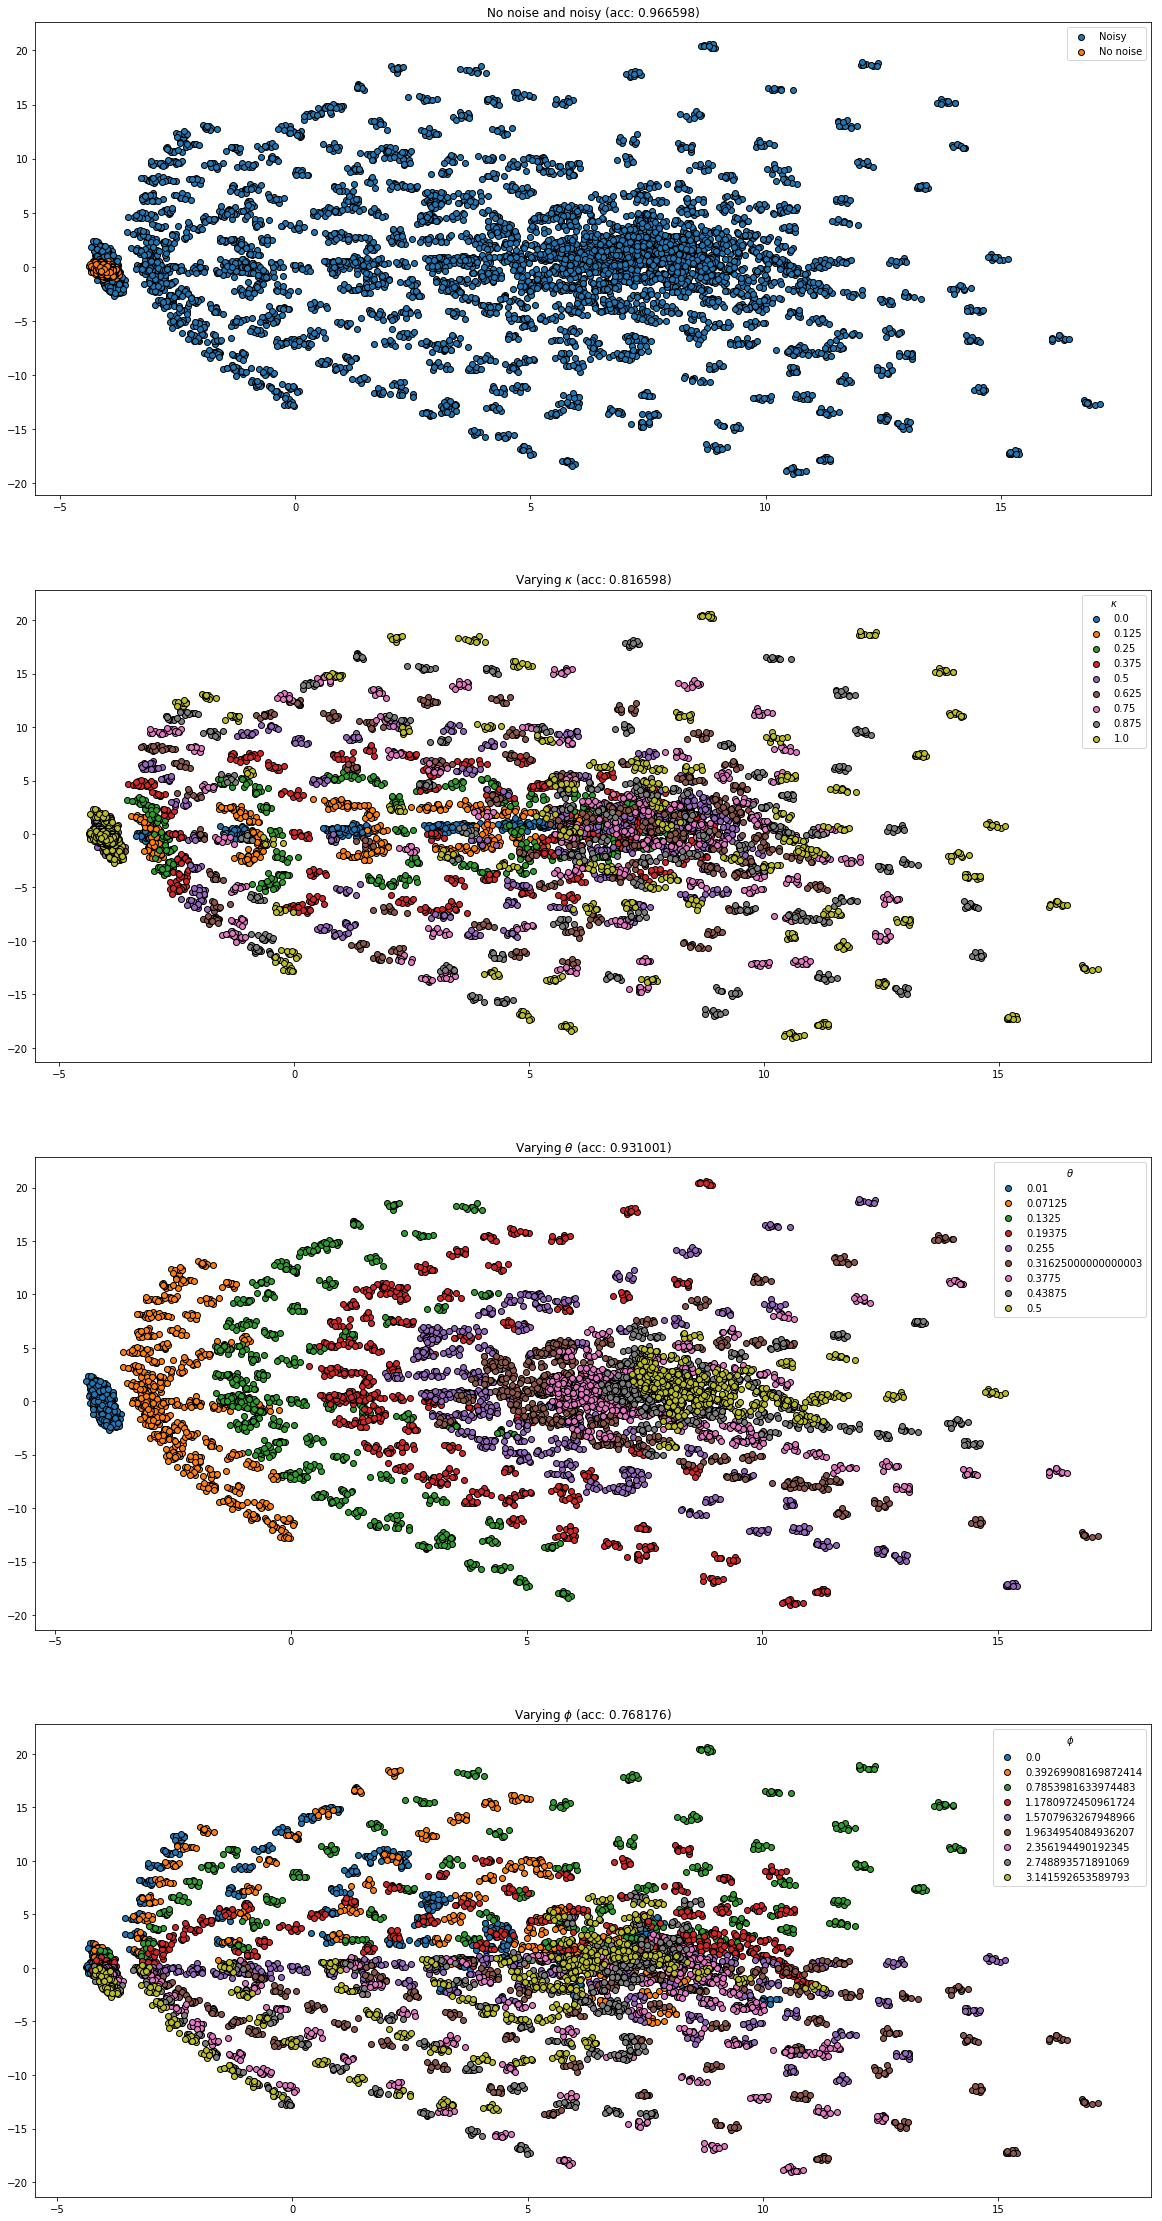

In [51]:
show_plots()

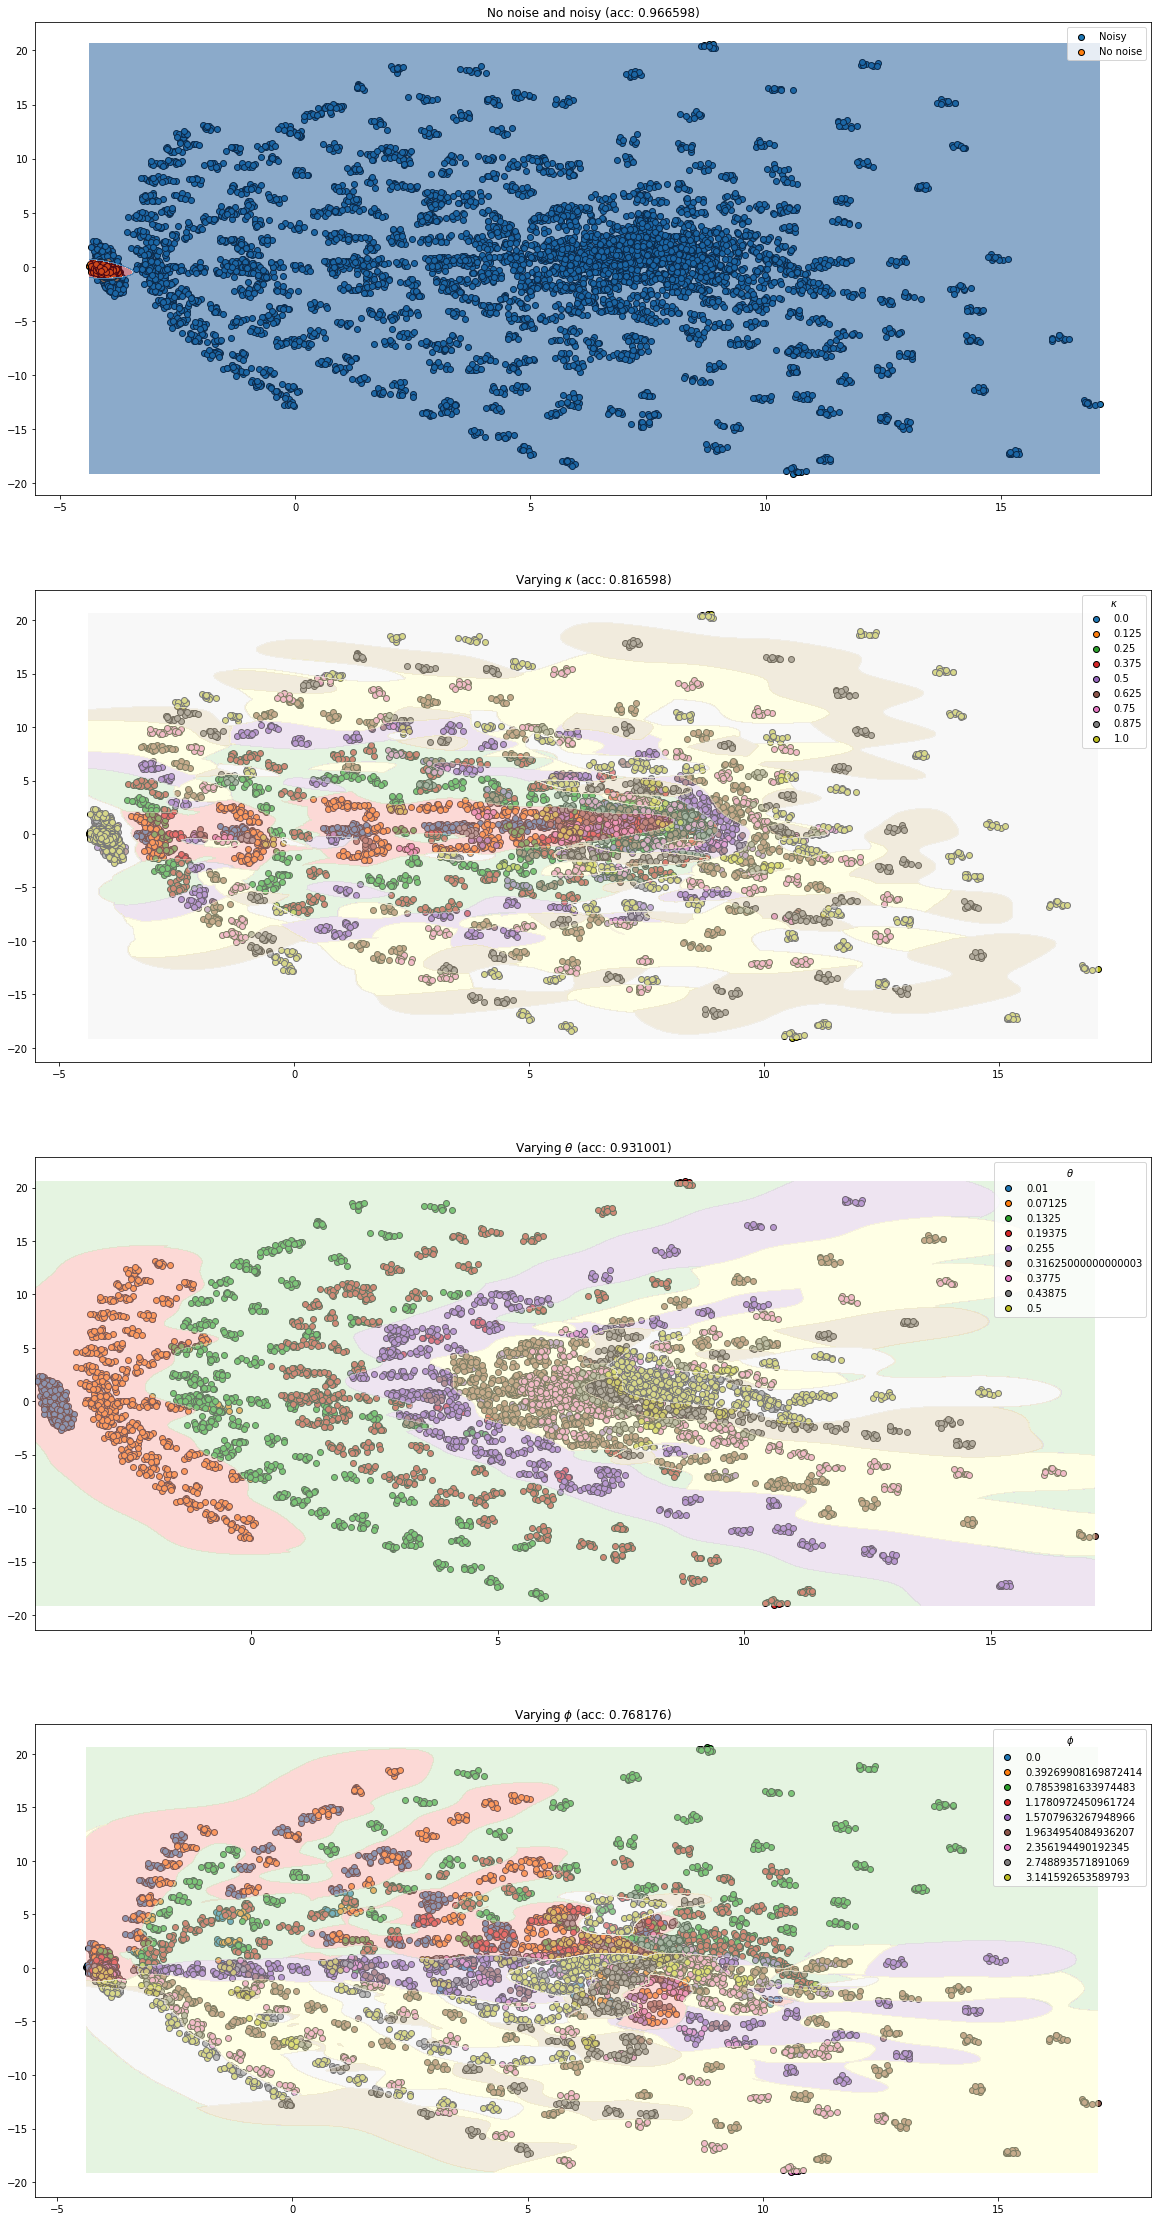

In [52]:
show_plots(True)

- For *fixed $\theta$* (noise strength), it seems possible to classify $\kappa$ (coherence). However, SVM may not provide a generlaizable fit where $\theta$ is unknown.
- $\theta$ (noise strength) nicely partititions the data into arcs!
- $\phi$ ($\sigma_X, \sigma_Y$ mixing) also appears approximately separable

Obviously, note that we are overfitting and the accuracies are determined on the **training** dataset. Let us plan to add cross-validation or a practical test set. Judging from the decision boundaries $\theta, \phi, \kappa$ seems to be the ordering from most to least generalizable. Also, note that accuracies are a reasonable metric because we have generated an equivalent number of samples from each class.